# Denoising autoencoders in JAX/Haiku

- Reconstruct original trajectories given original trajectory plus noise corruption
- Use recurrent model to encode and decode to/from latetent representation




References
- Boney et al., “Regularizing Trajectory Optimization with Denoising Autoencoders”
- Vincent et al., “Stacked Denoising Autoencoders.”

### Install haiku

In [34]:
!pip install jaxlib
# !pip install git+https://github.com/deepmind/dm-haiku
!pip install dm-haiku==0.0.5
!pip install box2D
!pip install git+git://github.com/deepmind/optax.git
!pip install SciencePlots


  Cloning git://github.com/deepmind/optax.git to /tmp/pip-req-build-oey9yuay
  Running command git clone -q git://github.com/deepmind/optax.git /tmp/pip-req-build-oey9yuay


### Load dependencies

In [35]:
import jax
import gym
import optax
import torch
import haiku as hk
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax import grad, jit, vmap
from typing import Generator, Mapping, Tuple

plt.style.reload_library()
plt.style.use(['science', 'no-latex', 'notebook'])
plt.rcParams['axes.facecolor'] = 'white'

# https://github.com/deepmind/dm-haiku
# https://github.com/google/jax
# https://github.com/deepmind/optax
# https://github.com/deepmind/dm-haiku/blob/main/examples/impala/haiku_nets.py

In [36]:
hk.__version__

'0.0.5'

# Data
Generate random trajectories 

In [37]:
env_name = "LunarLander-v2"
env = gym.make(env_name)

In [38]:
env.reset()
env.observation_space.shape

(8,)

In [39]:
def generate_trajectories(env, num_trajectories, trajectory_length):
    action_scale = 4
    trajectories = []
    for i in range(num_trajectories):
        state = env.reset()
        done = False
        trajectory = []
        while len(trajectory) < trajectory_length and not done:
            action = env.action_space.sample()
            new_state, _, done, _ = env.step(action)
            trajectory.append(np.hstack((state, action/action_scale)))
            state = new_state
        if len(trajectory) < trajectory_length:
            trajectory.extend([np.zeros(env.observation_space.shape)]*(trajectory_length - len(trajectory)))
        trajectories.append(np.array(trajectory))
    return trajectories
trajectories = generate_trajectories(env, 100, 23)


In [40]:
trajectories[0].shape

(23, 9)

In [41]:

class TrajectoryDataset():
    def __init__(self, trajectories, noise_sigma, batch_size):
        self.input_data = self._noisify(trajectories, noise_sigma)
        self.target_data = [t[:, :8] for t in trajectories]
        self.batch_size = batch_size
        self.max = (self.__len__() // batch_size) * batch_size
        self._generate_batches()
        
    def _generate_batches(self):    
        self.batches = np.random.permutation(self.max).reshape((-1, self.batch_size))
    
    def __iter__(self):
        self.num = 0
        return self
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return (np.array([self.input_data[i] for i in self.batches[idx]]),
                np.array([self.target_data[i] for i in self.batches[idx]]))
    
    def __next__(self):
        if(self.num > len(self.batches)-1):
            raise StopIteration
        self.num += 1
        return self.__getitem__(self.num-1)

    def _noisify(self, data, noise_sigma):
        new_data = [0]*len(data)
        for i, d in enumerate(data):
            new_data[i] = d * np.random.normal(1, noise_sigma, size=d.shape)
        return new_data



# DAE

## Encoder/Decoder

In [42]:
class Encoder(hk.RNNCore):
    # note, latent state isn't currently used, instead the final hidden state
    # of the encoder is passed to the decoder
    def __init__(self, hidden_size: int=32, latent_size: int = 64, 
                 input_size: int = 8, name=None):
        super().__init__(name=name)
        self._hidden_size = hidden_size
        self._latent_size = latent_size
        self._input_size = input_size

    def initial_state(self, batch_size):
        if batch_size is None:
            shape = (self._hidden_size)
        else:
            shape = (batch_size, self._hidden_size)
        return jnp.zeros(shape)

    def __call__(self, x, state) -> jnp.ndarray:
        x, state = hk.VanillaRNN(self._hidden_size)(x, state)
        return x, state

class Decoder(hk.RNNCore):
    def __init__(self, hidden_size: int=32, latent_size: int = 64, 
                 output_size: int = 8, steps :int =20, name=None):
        super().__init__(name=name)
        self._hidden_size = hidden_size
        self._latent_size = latent_size
        self._output_size = output_size
        self._steps = steps

    def initial_state(self, batch_size):
        if batch_size is None:
            shape = (self._hidden_size)
        else:
            shape = (batch_size, self._hidden_size)
        self._batch_size = batch_size
        return jnp.zeros(shape)

    def __call__(self, x, state) -> jnp.ndarray:
        y = jnp.zeros((x.shape[0],self._steps,self._output_size))
        # need to reconstruct trajectory from hidden state,
        # have to loop over RNN since only have first input
        # to start with
        for i in range(self._steps):
            x, state = hk.VanillaRNN(self._hidden_size)(x, state)
            y=y.at[:,i,:].set(hk.Linear(self._output_size)(x))
        return y, state  


## Hyperparameters

In [43]:
HIDDEN_SIZE = 32
# LATENT_SIZE = 64
TIMESTEPS = 10
INPUT_STATE_SIZE = 9
OUTPUT_STATE_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 10
TRAJECTORIES = 10000
NOISE_SIGMA = 0.2


## Generate Data

In [44]:
trajectories = generate_trajectories(env, TRAJECTORIES, TIMESTEPS)
dataset = TrajectoryDataset(trajectories, NOISE_SIGMA, batch_size=BATCH_SIZE)


In [45]:
dataset.input_data[0][0], dataset.target_data[0][0], 

(array([-0.00341619,  1.31858494, -0.39677714,  0.05930802,  0.00253328,
         0.08104788,  0.        ,  0.        ,  0.51585653]),
 array([-0.00345554,  1.41234529, -0.35002235,  0.06332765,  0.00401088,
         0.0792853 ,  0.        ,  0.        ]))

In [46]:
def model_fn(batch) -> jnp.ndarray:
    # Note: this function is impure; we hk.transform() it below.
    encoder = Encoder(hidden_size=HIDDEN_SIZE, latent_size=LATENT_SIZE, 
                      input_size=INPUT_STATE_SIZE)
    decoder = Decoder(hidden_size=HIDDEN_SIZE, latent_size=LATENT_SIZE, 
                      output_size=OUTPUT_STATE_SIZE, steps=TIMESTEPS)
    batch_size, sequence_length, _ = batch.shape
    encoder_initial_state = encoder.initial_state(batch_size)

    # output is sequence, state
    _, encoded_state = hk.dynamic_unroll(encoder, 
                                        batch, 
                                        encoder_initial_state, 
                                        time_major=False)

    decoded_sequence, _ = hk.dynamic_unroll(decoder, 
                                            jnp.zeros((batch_size, 1, decoder._hidden_size)), 
                                            encoded_state, time_major=False)
    return decoded_sequence

## Initialize
- create optimizer
- transform model
- initial params
- set opt initial params

In [47]:
opt = optax.adam(1e-3)

model = hk.without_apply_rng(hk.transform(model_fn))

params = model.init(jax.random.PRNGKey(42), 
                    np.random.normal(0,1,(BATCH_SIZE,TIMESTEPS,INPUT_STATE_SIZE)))
opt_state = opt.init(params)

## Loss

In [48]:
@jax.jit
def loss_fn(params: hk.Params, batch) -> jnp.ndarray:
    decoded_sequence = model.apply(params, batch[0])
    return jnp.mean(jnp.square(batch[1] - decoded_sequence))

In [49]:
@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch) -> Tuple[hk.Params, optax.OptState]:
    grads = jax.grad(loss_fn)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

## Train

In [50]:
%%time
losses = []
for epoch in range(EPOCHS):
    for i,d in enumerate(dataset):
        params, opt_state = update(params, opt_state, d)
        if i % 50 == 0:
            loss = loss_fn(params, d)
            losses.append(loss)
            print(f"Epoch: {epoch}\tBatch: {i}\tLoss: {loss}")


Epoch: 0	Batch: 0	Loss: 0.2902948558330536
Epoch: 0	Batch: 50	Loss: 0.041328925639390945
Epoch: 0	Batch: 100	Loss: 0.03619953617453575
Epoch: 0	Batch: 150	Loss: 0.043551005423069
Epoch: 0	Batch: 200	Loss: 0.039037711918354034
Epoch: 0	Batch: 250	Loss: 0.044480107724666595
Epoch: 0	Batch: 300	Loss: 0.04669095203280449
Epoch: 1	Batch: 0	Loss: 0.04584938660264015
Epoch: 1	Batch: 50	Loss: 0.038098402321338654
Epoch: 1	Batch: 100	Loss: 0.03485680744051933
Epoch: 1	Batch: 150	Loss: 0.04279361292719841
Epoch: 1	Batch: 200	Loss: 0.03866168111562729
Epoch: 1	Batch: 250	Loss: 0.0440896600484848
Epoch: 1	Batch: 300	Loss: 0.04627833515405655
Epoch: 2	Batch: 0	Loss: 0.04561680182814598
Epoch: 2	Batch: 50	Loss: 0.03782212734222412
Epoch: 2	Batch: 100	Loss: 0.034648049622774124
Epoch: 2	Batch: 150	Loss: 0.04284852743148804
Epoch: 2	Batch: 200	Loss: 0.038463614881038666
Epoch: 2	Batch: 250	Loss: 0.04396839067339897
Epoch: 2	Batch: 300	Loss: 0.04623250290751457
Epoch: 3	Batch: 0	Loss: 0.045571438968181

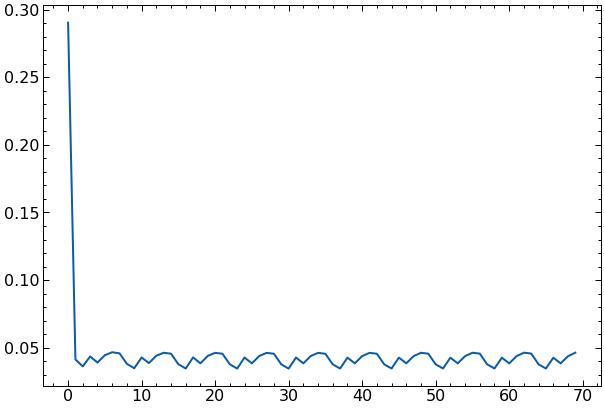

In [51]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.show()

## Test

In [52]:
idx = 42
noisy_traj = dataset[idx][0][0,:,:]
true_traj = dataset[idx][1][0,:,:]
predict = jnp.squeeze(model.apply(params, np.expand_dims(noisy_traj, axis=0)))


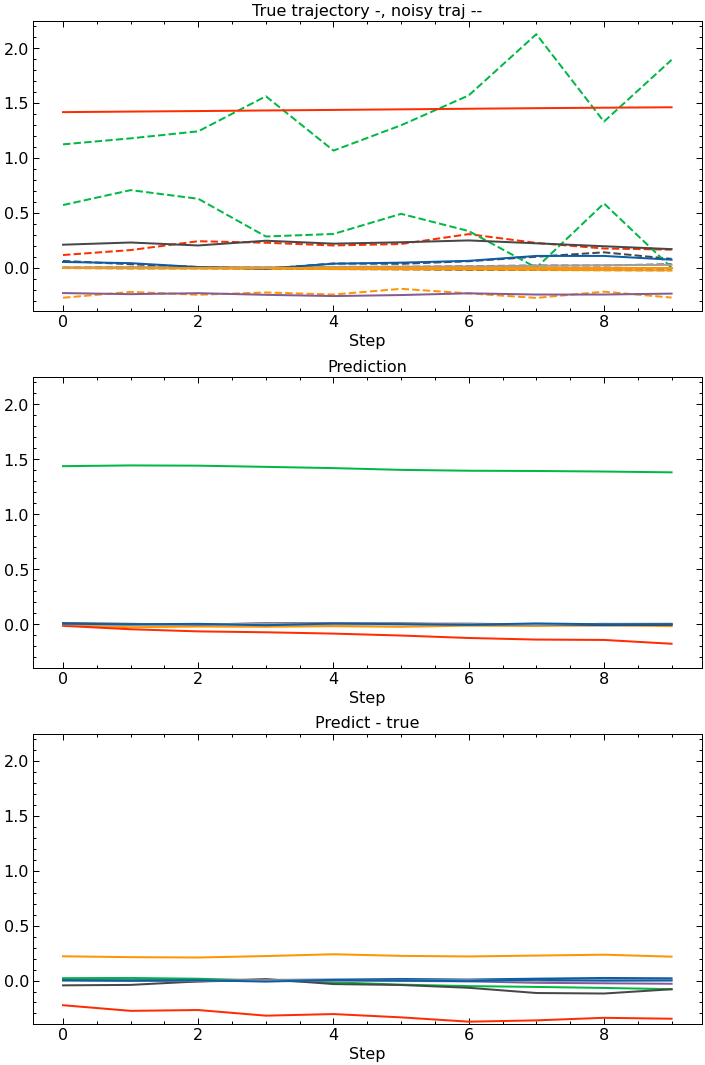

In [53]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.title('True trajectory -, noisy traj --')
plt.plot(noisy_traj, '--', label='noisy')
plt.plot(true_traj, label='true')
ax = plt.gca(); ylim = ax.get_ylim()
plt.xlabel('Step')
plt.subplot(3,1,2)
plt.title('Prediction')
plt.plot(predict)
plt.ylim(ylim)
plt.xlabel('Step')
plt.subplot(3,1,3)
plt.title('Predict - true')
plt.plot(predict - true_traj)
plt.ylim(ylim)
plt.xlabel('Step')
plt.tight_layout()
plt.show()

In [54]:
# fake inputs
noisy_traj =  np.random.normal(0, 1, size=(10,9))
true_traj = noisy_traj[:,:8]
predict = jnp.squeeze(model.apply(params, np.expand_dims(noisy_traj, axis=0)))

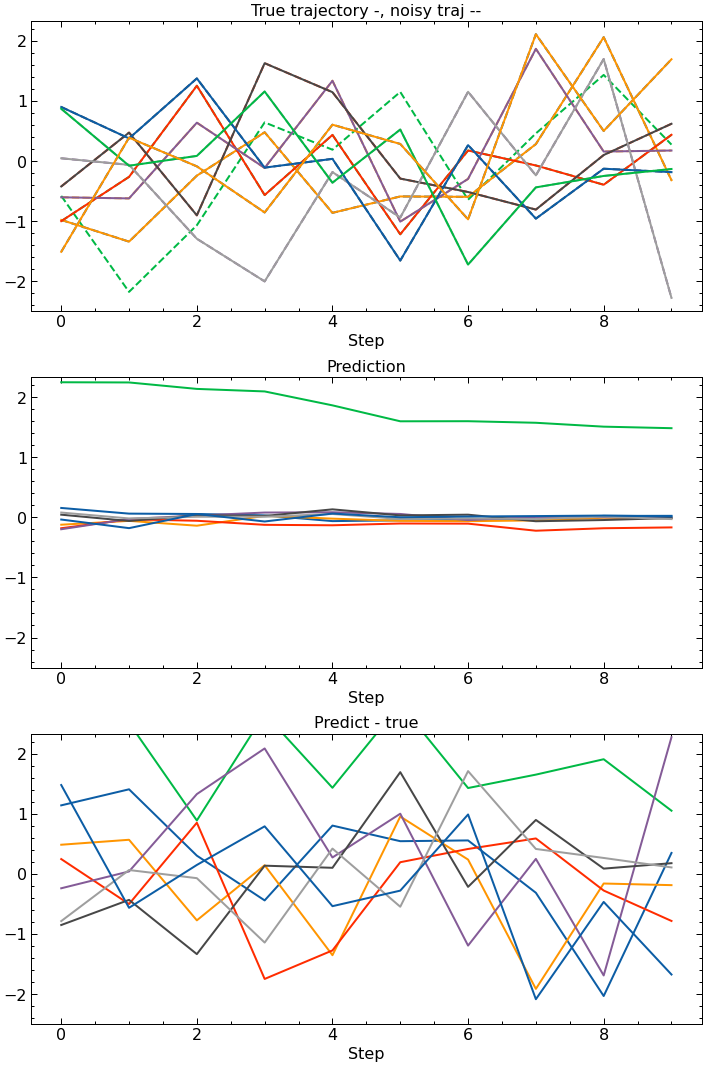

In [55]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.title('True trajectory -, noisy traj --')
plt.plot(noisy_traj, '--', label='noisy')
plt.plot(true_traj, label='true')
ax = plt.gca(); ylim = ax.get_ylim()
plt.xlabel('Step')
plt.subplot(3,1,2)
plt.title('Prediction')
plt.plot(predict)
plt.ylim(ylim)
plt.xlabel('Step')
plt.subplot(3,1,3)
plt.title('Predict - true')
plt.plot(predict - true_traj)
plt.ylim(ylim)
plt.xlabel('Step')
plt.tight_layout()
plt.show()